# Voting Classifier de K-vizinhos com diferentes visões geometrias

Este notebook visa fazer a otimização de **hiperparâmetros**, de estratégia de **normalização**, de **seleção de atributos** e de **redução de dimensionalidade**. A seleção de atributos é realizada por *Sequential Feature Selection* (**SFS**, ou Seleção Sequencial de Atributos em português) por remoção de atributo, a otimização testa a ausência ou não dessa estratégia. A redução de dimensionalidade é realizada por *Principal Component Analysis* (**PCA**, ou Análise de Componenetes Principais em português), é testada sua ausência também. Para normalização, são testadas a ausência, ou a normalização **padrão** ou a pelos **mínimos e máximos**. A otimização é feita usando o módulo **optuna**.

### Modelo

O algoritmo utilizado neste notebook é o K-nn classificador do módulo scikit-learn [2]. Funciona bem para conjuntos de dados complexos, com muitas dimensões, porém possui um problema em seu interior, um de seus hiperparâmetros: a necessidade de um método para saber as distâncias no espaço de atributos-eixo impõe o enviesamento para uma determinada interpretação geométrica a qual, a depender das informações que se têm sobre os atributos, pode não ser adequada - e para casos de muitos atributos, saber adequá-la representa um grande desafio. <br>

A distância euclidiana, por exemplo, calcula a raiz as somas em quadratura:
$$
d = \sqrt{\sum_i^n x_i^2}
$$
Note, pois, que nos casos em que as ordens dos valores são muito discrepantes, a medida de um atributo que for maior irá se impor no cálculo de distância antes as outras, não por ser efetivamente mais relevante para a predição do modelo, mas apenas por ser numericamente maior. Quanto mais dimensões, mais possibilidades de sobrepujança são possíveis, e o K-nn perde sua coerência. <br>
Dessa forma, achamos interessante consumar um modelo em caráter um pouco mais experimental: um Voting Classifier, "Congresso", de K-nn classificadores com diferentes métricas geométricas. <br>

Pode verificar que no notebook do modelo K-nn unitário é utilizado o "p-minkowski". A métrica de Minkowski é a forme de generalizar as distâncias em múltiplas dimensões [4]:
$$
D(X, Y) = \left( \sum_i^n |x_i-y_i|^p \right)^{\frac{1}{p}}
$$
A fórmula pode assumir um caráter um tanto abstrato quando se pretende visualizar geometricamente a distância, haja vista que p $\geq$ 1 (caso contrário, violaria a desigualdade triangular), e assim assume qualquer valor do intervalo contínuo. Ainda assim, a partir daqui podem ser obtidas geometrias interpretáveis, a distância euclidiana ($p = 2$), a Manhattan ($p = 1$) e a chebyshev ($lim\ p \rightarrow \infty$):

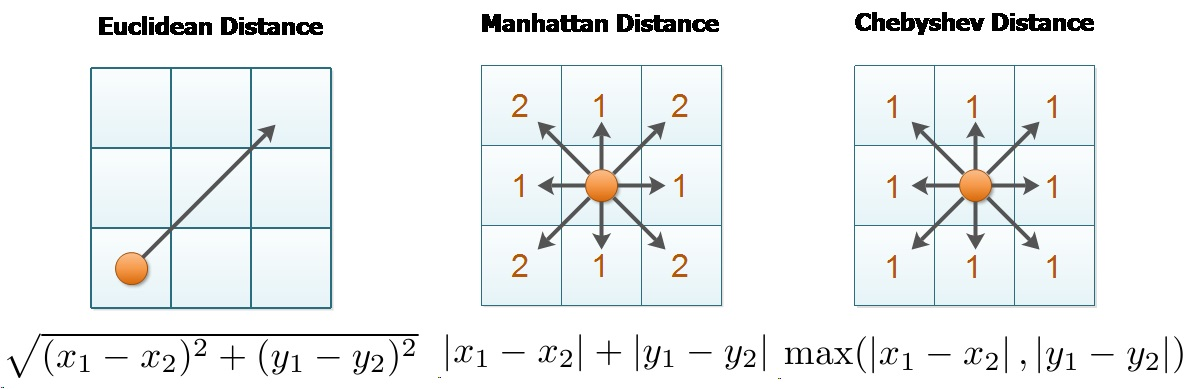
<sub><sup> Visualização das 3 métricas de distância citadas. Fonte: OpenGenus IQ - Euclidean vs Manhattan vs Chebyshev Distance [5]. Disponível em: https://iq.opengenus.org/euclidean-vs-manhattan-vs-chebyshev-distance/. Acesso em: 01 nov. 2025. </sup></sub>

A ideia de um **Voting Classifier** [6] **de K-nns de diferentes funções de métrica** já foi proposta por BAO, Y.; ISHII, N.; e DU, X. (2004) [7], em que utilizaram principalmente da discretização dos atributos e de modificação da distância euclidiana para os diferentes K-nns votantes; inspirados nisso, queremos investigar a construções de um congresso de K-nns classificadores composto por 11 instâncias em que todas compartilharão dos mesmo hiperparâmetros senão da métrica de distância, as quais serão as 3 exibidas atrás. O objetivo é verificar se as instabilidades geométricas de cada métrica são compensadas pelo coletivo, e como há 11 instâncias* e 3 métricas, o Optuna irá otimizar na direção de ao menos 1 das métricas se tornar dominante. A proporção de métricas em cada instância de K-nn será um claro fator de otimização.

*A quantia 11 foi escolhida por ser ímpar; para além disso, arbitrariamente. 11 é o número de cargos de ministros no Supremo Tribunal Federal [8].

Os hiperparâmetros presentes são: <br>
* `Voting`: "hard", em que a votação ocorre por valor absoluto, por contagem de votos em cada classe do target, e "soft", em que cada votante submete a probabilidade de ser cada classe, e disso é extraída a média ponderada para cada uma - a maior média converte-se na previsão;
* `knn_n_neighbors`: quantidade de vizinhos comum a todos os votantes;
* `knn_weights`: cálculo da relevância dos k-vizinhos próximos: se "uniform", todos têm mesma influência; se "distance", a relevância é inversamente proporcional à distância
* `_[v]knn__metric`: a métrica de cada modelo unitário votante - são três possíveis, "euclidean", "manhattan" e "chebyshev".

## Carregamento dos dados

In [1]:
from pandas import read_csv

# Dados de treino
X_treino = read_csv('../Dados/dados_tratados/X_treino.csv')
y_treino = read_csv('../Dados/dados_tratados/y_treino.csv').values.ravel()

In [2]:
from sklearn.metrics import fbeta_score, make_scorer

# Parâmetros
f2_score = make_scorer(fbeta_score, beta=2) # Métrica de avaliação de desempenho
SEMENTE_ALEATORIA = 9 # Random state
num_max_atributos = len(X_treino.columns) - 1

X_treino = X_treino.values

Antes de seguir, precisamos criar uma **função auxiliar** capaz de encaminhar corretamente cada hiperparâmetro individual que o optuna oferecer ao congresso, além de generalizar os outros parâmetros.

In [3]:
def respector(voting_classifier_instance, dict_parametros):

    params = {}

    for nome_param, parametro in dict_parametros.items():
    
        # Hiperparâmetros comuns a todos os k-NNs votantes
        if nome_param[0] == "k":
            for i in range(1, 12):
                nome_ = f"_{i}{nome_param}"
                def_ = parametro
                params[nome_] = def_
            
        # Hiperparâmetros do VotingClassifier e métricas e cada votante
        else:
            nome_ = nome_param
    
            if nome_param[0] == "_":
                def_ = parametro
    
            else:
                def_ = parametro
                
            params[nome_] = def_
        
    voting_classifier_instance.set_params(**params)

## Definição de funções para o optuna

O código abaixo define a função que cria uma instância do modelo. É nela que a pipeline é montado de acordo com as sugestões definidas pelo optuna.

In [4]:
from sklearn.neighbors import KNeighborsClassifier # algoritmo de aprendizado de máquina
from sklearn.ensemble import VotingClassifier # congregador de algoritmos
from sklearn.preprocessing import StandardScaler, MinMaxScaler # normalização
from sklearn.feature_selection import SequentialFeatureSelector # seleção de atributos
from sklearn.decomposition import PCA # redução de dimensionalidade
from sklearn.pipeline import make_pipeline

def cria_instancia_modelo(trial):
    """Cria uma instância do modelo.

    Args:
      trial: objeto tipo Trial do optuna.

    Returns:
      Uma instância do modelo desejado.

    """

    # Define as instâncias dos K-nns votantes previamente    
    _1knn = KNeighborsClassifier()
    _2knn = KNeighborsClassifier()
    _3knn = KNeighborsClassifier()
    _4knn = KNeighborsClassifier()
    _5knn = KNeighborsClassifier()
    _6knn = KNeighborsClassifier()
    _7knn = KNeighborsClassifier()
    _8knn = KNeighborsClassifier()
    _9knn = KNeighborsClassifier()
    _10knn = KNeighborsClassifier()
    _11knn = KNeighborsClassifier()

    congresso_knn = VotingClassifier(estimators=[
    ('_1knn', _1knn),
    ('_2knn', _2knn),
    ('_3knn', _3knn),
    ('_4knn', _4knn),
    ('_5knn', _5knn),
    ('_6knn', _6knn),
    ('_7knn', _7knn),
    ('_8knn', _8knn),
    ('_9knn', _9knn),
    ('_10knn', _10knn),
    ('_11knn', _11knn)
])
    
    parametros = {
        "voting": trial.suggest_categorical("votacao", ["hard", "soft"]), 
        "n_jobs": -1,
        "knn__n_neighbors": trial.suggest_int("vizinhos", 2, 80),
        "knn__weights": trial.suggest_categorical("pesos", ["uniform", "distance"]),
        "_1knn__metric": trial.suggest_categorical("metrica1", ["euclidean", "manhattan", "chebyshev"]),
        "_2knn__metric": trial.suggest_categorical("metrica2", ["euclidean", "manhattan", "chebyshev"]),
        "_3knn__metric": trial.suggest_categorical("metrica3", ["euclidean", "manhattan", "chebyshev"]),
        "_4knn__metric": trial.suggest_categorical("metrica4", ["euclidean", "manhattan", "chebyshev"]),
        "_5knn__metric": trial.suggest_categorical("metrica5", ["euclidean", "manhattan", "chebyshev"]),
        "_6knn__metric": trial.suggest_categorical("metrica6", ["euclidean", "manhattan", "chebyshev"]),
        "_7knn__metric": trial.suggest_categorical("metrica7", ["euclidean", "manhattan", "chebyshev"]),
        "_8knn__metric": trial.suggest_categorical("metrica8", ["euclidean", "manhattan", "chebyshev"]),
        "_9knn__metric": trial.suggest_categorical("metrica9", ["euclidean", "manhattan", "chebyshev"]),
        "_10knn__metric": trial.suggest_categorical("metrica10", ["euclidean", "manhattan", "chebyshev"]),
        "_11knn__metric": trial.suggest_categorical("metrica11", ["euclidean", "manhattan", "chebyshev"]),
    }

    # Entrega a cada instância K-nn e ao conjunto VotingCLassifier os hiperparâmetros corretos
    respector(congresso_knn, parametros)
    
    normalizacao = trial.suggest_categorical("normalizacao", ["none", "standard", "minmax"])
    usar_sfs = trial.suggest_categorical("SFS", [True, False])
    usar_pca = trial.suggest_categorical("PCA", [True, False])

    num_atributos = trial.suggest_int("num_atributos", 2, num_max_atributos) # para SFS
    num_dimensoes = trial.suggest_int("num_dimensoes", 2, num_atributos) # para PCA
        
    
    steps = []

    if normalizacao == "standard":
        steps.append(("normalizador", StandardScaler()))
    elif normalizacao == "minmax":
        steps.append(("normalizador", MinMaxScaler()))

    if usar_sfs:
        steps.append(("sfs", SequentialFeatureSelector(
            congresso_knn, 
            n_features_to_select=num_atributos,
            direction="backward",
            scoring=f2_score,
            cv=5,
            n_jobs=1,
        )))

    if usar_pca:
        steps.append(("pca", PCA(n_components=num_dimensoes, random_state=SEMENTE_ALEATORIA)))

    steps.append(("modelo", congresso_knn))

    modelo = make_pipeline(*[s[1] for s in steps])

    return modelo

O código abaixo define a função que estima o desempenho do modelo de cada trial. Essa é a função que terá valor de retorno maximizado pelo optuna.

In [5]:
from sklearn.model_selection import cross_val_score
import numpy as np

def funcao_objetivo(trial, X, y, num_folds):
    """Função objetivo do optuna.

    Faz validação cruzada estratificada com métrica F2.

    """
    modelo = cria_instancia_modelo(trial)

    metricas = cross_val_score(
        modelo,
        X,
        y,
        scoring=f2_score,
        cv=num_folds,
    )

    return np.mean(metricas)

In [6]:
from optuna import create_study

NOME_DO_ESTUDO = "Knn_congress_class_optuna"

objeto_de_estudo = create_study(
    direction="maximize",
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True,
)

[I 2025-11-03 22:44:24,982] A new study created in RDB with name: Knn_congress_class_optuna


In [7]:
NUM_FOLDS = 10 # Número de folds da validação cruzada
NUM_TENTATIVAS = 200 # Quantidade de trials

def funcao_objetivo_parcial(trial):
    return funcao_objetivo(trial, X_treino, y_treino, NUM_FOLDS)

# Faz a otimização
objeto_de_estudo.optimize(funcao_objetivo_parcial, n_trials=NUM_TENTATIVAS)

[I 2025-11-03 22:45:08,751] Trial 0 finished with value: 0.7836618701154466 and parameters: {'votacao': 'hard', 'vizinhos': 41, 'pesos': 'uniform', 'metrica1': 'manhattan', 'metrica2': 'manhattan', 'metrica3': 'chebyshev', 'metrica4': 'chebyshev', 'metrica5': 'euclidean', 'metrica6': 'euclidean', 'metrica7': 'euclidean', 'metrica8': 'chebyshev', 'metrica9': 'manhattan', 'metrica10': 'euclidean', 'metrica11': 'euclidean', 'normalizacao': 'standard', 'SFS': True, 'PCA': True, 'num_atributos': 7, 'num_dimensoes': 5}. Best is trial 0 with value: 0.7836618701154466.
[I 2025-11-03 22:45:09,855] Trial 1 finished with value: 0.8163868338907729 and parameters: {'votacao': 'hard', 'vizinhos': 56, 'pesos': 'uniform', 'metrica1': 'manhattan', 'metrica2': 'chebyshev', 'metrica3': 'chebyshev', 'metrica4': 'euclidean', 'metrica5': 'chebyshev', 'metrica6': 'manhattan', 'metrica7': 'chebyshev', 'metrica8': 'chebyshev', 'metrica9': 'euclidean', 'metrica10': 'euclidean', 'metrica11': 'manhattan', 'normal

## DataFrame dos trials

O código abaixo mostra o DataFrame contruído pelo objeto de estudo do optuna contendo todos os parâmetros de cada trial.

In [8]:
df_analysis = objeto_de_estudo.trials_dataframe()

df_analysis

,number,value,datetime_start,datetime_complete,duration,params_PCA,params_SFS,params_metrica1,params_metrica10,params_metrica11,...,params_metrica7,params_metrica8,params_metrica9,params_normalizacao,params_num_atributos,params_num_dimensoes,params_pesos,params_vizinhos,params_votacao,state
0,0,0.783662,2025-11-03 22:44:24.997059,2025-11-03 22:45:08.677610,0 days 00:00:43.680551,True,True,manhattan,euclidean,euclidean,...,euclidean,chebyshev,manhattan,standard,7,5,uniform,41,hard,COMPLETE
1,1,0.816387,2025-11-03 22:45:08.761404,2025-11-03 22:45:09.839425,0 days 00:00:01.078021,False,False,manhattan,euclidean,manhattan,...,chebyshev,chebyshev,euclidean,none,6,6,uniform,56,hard,COMPLETE
2,2,0.819068,2025-11-03 22:45:09.865435,2025-11-03 22:45:10.479631,0 days 00:00:00.614196,True,False,euclidean,chebyshev,manhattan,...,euclidean,chebyshev,manhattan,none,3,3,uniform,59,hard,COMPLETE
3,3,0.834008,2025-11-03 22:45:10.556529,2025-11-03 22:46:18.033355,0 days 00:01:07.476826,False,True,euclidean,chebyshev,euclidean,...,euclidean,manhattan,euclidean,minmax,3,2,distance,33,soft,COMPLETE
4,4,0.844117,2025-11-03 22:46:18.084297,2025-11-03 22:47:23.215562,0 days 00:01:05.131265,True,True,euclidean,euclidean,euclidean,...,euclidean,chebyshev,euclidean,none,3,2,distance,47,hard,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,0.882661,2025-11-04 02:18:44.482039,2025-11-04 02:20:18.057938,0 days 00:01:33.575899,True,True,manhattan,manhattan,chebyshev,...,euclidean,manhattan,chebyshev,none,5,4,uniform,59,hard,COMPLETE
196,196,0.872696,2025-11-04 02:20:18.087120,2025-11-04 02:21:44.768901,0 days 00:01:26.681781,True,True,manhattan,manhattan,chebyshev,...,euclidean,manhattan,chebyshev,none,5,4,uniform,30,hard,COMPLETE
197,197,0.884439,2025-11-04 02:21:44.852795,2025-11-04 02:23:22.483872,0 days 00:01:37.631077,True,True,manhattan,manhattan,chebyshev,...,euclidean,manhattan,chebyshev,none,5,4,uniform,75,hard,COMPLETE
198,198,0.885597,2025-11-04 02:23:22.522379,2025-11-04 02:24:56.034000,0 days 00:01:33.511621,True,True,manhattan,manhattan,chebyshev,...,euclidean,manhattan,chebyshev,none,5,4,uniform,70,hard,COMPLETE


## Melhor modelo

O código abaixo mostra o melhor modelo encontrado pelo optuna e seus hiperparâmetros. Note que os parâmetros "num_atributos" e "num_dimensoes" só influenciam caso "SFS" e "PCA" sejam True respectivamente, pois são seus respectivos hiperparâmetros.

In [9]:
melhor_trial = objeto_de_estudo.best_trial

print(f"Número do melhor trial: {melhor_trial.number}")
print(f"Parâmetros do melhor trial: {melhor_trial.params}")

Número do melhor trial: 77
Parâmetros do melhor trial: {'votacao': 'hard', 'vizinhos': 71, 'pesos': 'uniform', 'metrica1': 'manhattan', 'metrica2': 'manhattan', 'metrica3': 'manhattan', 'metrica4': 'manhattan', 'metrica5': 'manhattan', 'metrica6': 'euclidean', 'metrica7': 'euclidean', 'metrica8': 'manhattan', 'metrica9': 'chebyshev', 'metrica10': 'euclidean', 'metrica11': 'euclidean', 'normalizacao': 'none', 'SFS': True, 'PCA': True, 'num_atributos': 5, 'num_dimensoes': 4}


Este notebook se encerra aqui. O modelo será usado no notebook chamado 'Resultados_Discussão'.

## Referências

[1] Documentação do optuna. Acesso em: 31/10/2025. Disponível em: https://optuna.readthedocs.io/en/stable/ 

[2] Página do K-nn classificador da documentação do scikit-learn. Acesso em: 31/10/2025. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier 

[3] Sperat, Walter. *Using optuna with sklearn the right way*. Acesso em 31/10/2025. Disponível em: https://medium.com/@walter_sperat/using-optuna-with-sklearn-the-right-way-part-1-6b4ad0ab2451

[4] Chugani, Vinod. *Minkowski Distance: A Comprehensive Guide*. Acesso em 01/11/2025. Disponível em: https://www.datacamp.com/tutorial/minkowski-distance

[5] Página do Voting Classifier da documentação do scikit-learn. Acesso em 01/11/2025. Disponível em: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier.set_params

[6] BAO, Y.; ISHII, N.; DU, X. Combining Multiple k-Nearest Neighbor
Classifiers Using Different Distance Functions. **IDEAL**, Exeter, v. 5. p. 634-641, Ago. 2004. Disponível em: https://link.springer.com/book/10.1007/b99975. Acesso em: 1 nov. 2025.

[7]  Chatterjee, Aditya. *Euclidean vs Manhattan vs Chebyshev Distance*. Acesso em: 01/11/2025. Disponível em: https://iq.opengenus.org/euclidean-vs-manhattan-vs-chebyshev-distance/

[8] Home do Supremo Tribunal Federal (STF). Acesso em: 01/11/2025. Disponível em: https://portal.stf.jus.br/ostf/